In [1]:
import pytorch_lightning as pl
import cv2
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
import glob as glob
import os

from model.model import CSRNet
from utils.dataset import Sha, collate_fn

In [2]:
test_dir = 'Shanghai/part_A_final/test_data/'

# Load images and corresponding density maps
test_image_files = sorted(glob.glob(os.path.join(test_dir,'images', '*.jpg')))
test_density_map_files = sorted(glob.glob(os.path.join(test_dir,'densities', '*.h5')))

print(f"Lenght of test images: {len(test_image_files)}")
print(f"Lenght of test density maps: {len(test_density_map_files)}")

# create a dataset
test_images = [Image.open(img_file).convert('RGB') for img_file in test_image_files]
test_density_maps = [h5py.File(dm_file, 'r') for dm_file in test_density_map_files]
test_density_maps = [np.asarray(density_map['density']) for density_map in test_density_maps]

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
])

Lenght of test images: 182
Lenght of test density maps: 182


In [3]:
model = CSRNet(learning_rate=1e-7)
model.load_from_checkpoint('lightning_logs/version_0/checkpoints/model-epoch=56-val_loss=6.23.ckpt', learning_rate=1e-7)

model.eval()

CSRNet(
  (frontend): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted count: -0.05222461372613907
Ground truth count: 171.93138122558594


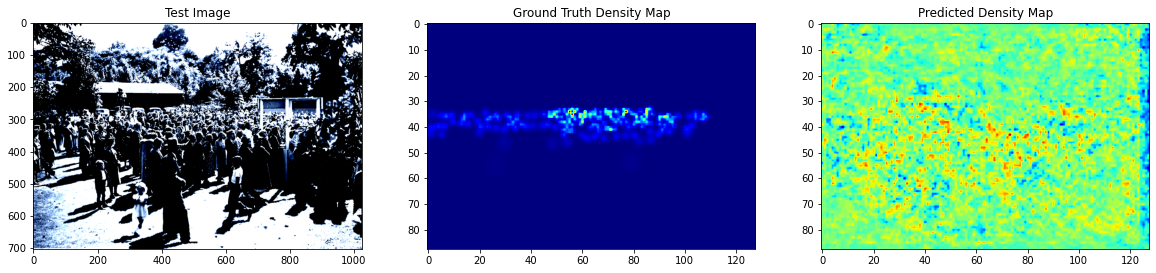

In [5]:
# perform inference on a single image
test_image = test_images[0]
test_density_map = test_density_maps[0]
test_image = test_transform(test_image).unsqueeze(0)
# resize the density map to 1/8 the size of the original image
test_density_map = cv2.resize(test_density_map, (int(test_image.shape[3]/8), int(test_image.shape[2]/8))) * 64

pred_density_map = model(test_image).squeeze().detach().numpy()

print(f"Predicted count: {np.sum(pred_density_map)}")
print(f"Ground truth count: {np.sum(test_density_map)}")

plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.imshow(test_image.squeeze().permute(1, 2, 0))
plt.title('Test Image')
plt.subplot(1, 3, 2)
plt.imshow(test_density_map, cmap='jet')
plt.title('Ground Truth Density Map')
plt.subplot(1, 3, 3)
plt.imshow(pred_density_map, cmap='jet')
plt.title('Predicted Density Map')
plt.show()